# Geometric Brownian motion
$$ G_t=G_0 e^{\left[\left(\mu-\frac{\sigma^2}{2}\right)t+\sigma Z_t\right]} $$ <br>
\begin{aligned}
Z_t &= \text{Displacement}\left[x_\tau|\mathcal{N}(0,1^2)\right]=\sum_{\tau=0}^T{d\sim \mathcal{N}(0,1^2)}
\end{aligned}

\begin{aligned}
&E[G_t] = G_0e^{\mu t}\\
&V[G_t] = G_0^2 e^{2\mu t}\left(e^{\sigma^2t}-1\right)
\end{aligned}

In [2]:
import numpy as np
import matplotlib.pyplot as plt

from numpy.random import normal

def geometric_movement(t, drift=0.1, volatility=0.01, g0=10):
    if not isinstance(t, np.ndarray):
        t = np.array(t)
    return g0*np.exp((drift-0.5*volatility**2)*t)
    # return g0*np.exp(drift*t)

def standard_movement(t, dt=None):
    n = len(t) if isinstance(t, (np.ndarray, list, tuple)) else 1
    std = np.random.standard_normal(size=n)
    return np.cumsum(std)*np.sqrt(dt if dt is not None else t[1]-t[0])

def gbm(t, drift=0.1, volatility=0.01, g0=10, dt=None):
    return geometric_movement(t, drift, volatility, g0) * np.exp(volatility*standard_movement(t, dt))

## Check Hyperparameters

3.5e-05 0.0009449


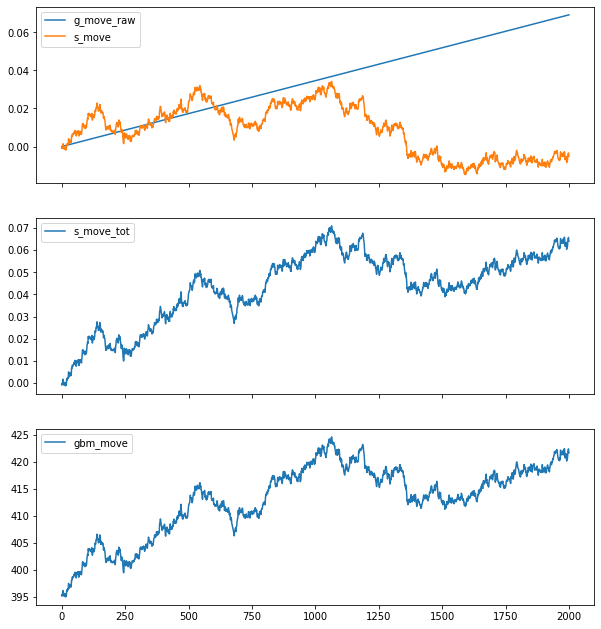

In [3]:
volatility = normal(1e-3, 1e-4)
drift = (5e-5 + normal(0, 5e-5)) * np.random.choice([1,-1])
g0 = normal(500, 50)

t = np.arange(2000)
dt = t[1]-t[0]
args = [drift, volatility, 1]

g_move = geometric_movement(t, *args)
g_move_raw = np.log(g_move)
s_move = volatility*standard_movement(t, dt)
s_move_tot = g_move_raw + s_move
gbm_move = g0*np.exp(s_move_tot)

print(round(args[0], 7), round(args[1], 7))

plt.figure(figsize=(10,11))
ax1 = plt.subplot(3,1,1)
plt.xticks(visible=False)
plt.plot(t, g_move_raw, label='g_move_raw')
plt.plot(t, s_move, label='s_move')
plt.legend()

plt.subplot(3,1,2, sharex=ax1)
plt.xticks(visible=False)
plt.plot(t, s_move_tot, label='s_move_tot')
plt.legend()

plt.subplot(3,1,3, sharex=ax1)
plt.plot(t, gbm_move, label='gbm_move')

plt.legend()
plt.show()

# Simulation Scratch

## Market
- each market has its own stock group.
### stock group
- each stock group has its own $\mu$ (large scale movement)
### stock
- each stock in group has its own $\sigma, p_0, p_{\text{min}}$ (volatility, initial price, price tick size)

## OrderBook
- Instrument
    which to buy/sell
- Price
- Quantity
    default: 1000
- Side
    [buy|sell]

## FCN Agent
- future price prediction
    \begin{aligned}
    F&=\frac{1}{T}\log{\frac{p_f(t)}{p(t)}} \\
    C&=\frac{1}{T}\log{\frac{p(t)}{p_{t-\tau}(t)}}\\
    N&\sim\mathcal{N}(\mu, \sigma^2)\\
    \end{aligned}

    $$ \therefore r=\frac{w_FF+w_CC+w_NN}{w_F+w_C+w_N} $$
    $$ p_{t+\tau}=p_te^{r\tau} $$

- time window size ($\tau$)
    FCN agent's resting interval

### Transaction Making
- order margin ($k$)
- Buy
    submit buy order $(1-k)p_{t+\tau}$ if $p_{t+\tau} > p_t$
- Sell
    submit sell order $(1+k)p_{t+\tau}$ if $p_{t+\tau} < p_t$
- Submit volume
    $v\sim u\{1,5\}$

# Simulation Test

## 1. Price Movement Test

### Objective
- make reasonable fundamental price movement

In [14]:
import numpy as np
from numpy.random import normal
from numpy.random import standard_normal as std_normal

def gbm_movement(t, drift, volatility, g0, dt=0, drift_as_trend=False):
    trend = drift if drift_as_trend else drift - 0.5*volatility**2
    g_move = trend * t
    s_move = np.cumsum(std_normal(len(t))) * volatility * np.sqrt(dt if dt else t[1]-t[0])
    gbm = g0 * np.exp(g_move + s_move)

    return g_move, s_move, gbm

In [15]:
SEED = 42
np.random.seed(SEED)

mu_config = (1e-4, 1e-4)
sigma_config = (1e-2, 1e-3)

mu, sigma = normal(*mu_config), normal(*sigma_config)
g0 = normal(500, 50)

t = np.arange(10000)

g_move, s_move, gbm = gbm_movement(t, mu, sigma, g0, drift_as_trend=True)

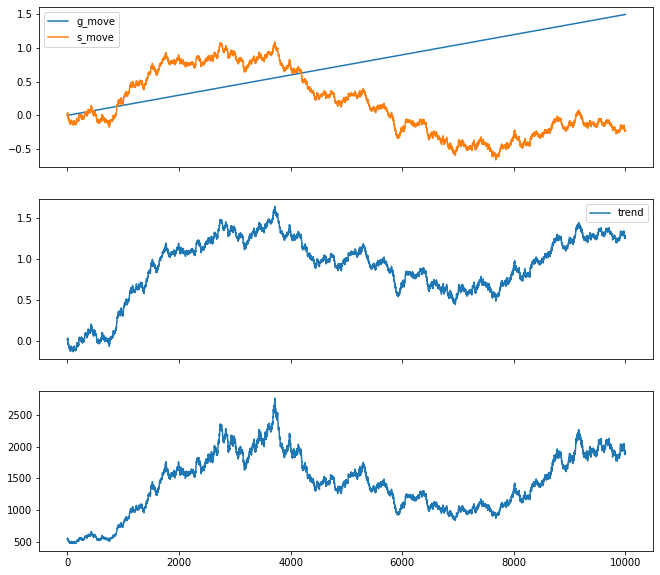

In [16]:
import matplotlib.pyplot as plt

def plot_detail(g_move, s_move, gbm):
    fig = plt.figure(figsize=(11, 10))
    ax = plt.subplot(3,1,1)
    plt.xticks(visible=False)
    plt.plot(t, g_move, label='g_move')
    plt.plot(t, s_move, label='s_move')
    plt.legend()

    plt.subplot(3,1,2, sharex=ax)
    plt.xticks(visible=False)
    plt.plot(t, g_move+s_move, label='trend')
    plt.legend()

    plt.subplot(3,1,3)
    plt.plot(gbm)

    plt.show()

plot_detail(g_move, s_move, gbm)